In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [2]:
from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot

In [3]:
consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_3 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 0.3) for _ in range(3)]

powerball_3 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(3)]

dist_N = consistent_4 + highvar_3 +powerball_3

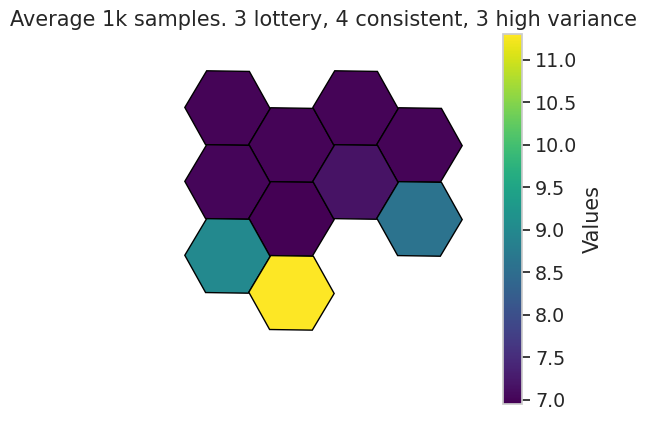

In [4]:
sample_and_plot(dist_N, size=1000, average=True, title='Average 1k samples. 3 lottery, 4 consistent, 3 high variance')

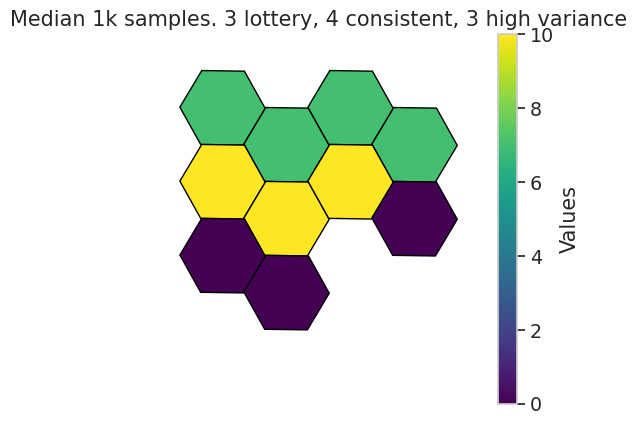

In [5]:
sample_and_plot(dist_N, size=1000, median=True, title='Median 1k samples. 3 lottery, 4 consistent, 3 high variance')

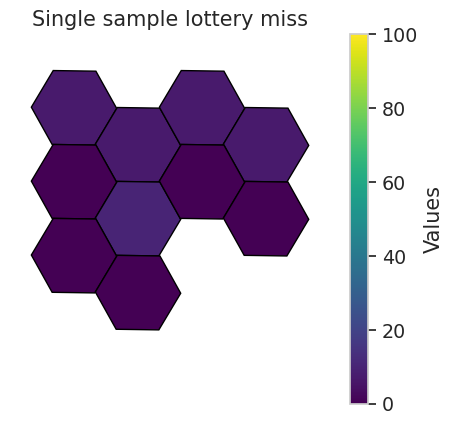

In [5]:
sample_and_plot(dist_N, size=1000, average=False, index=-1, title='Single sample lottery miss')

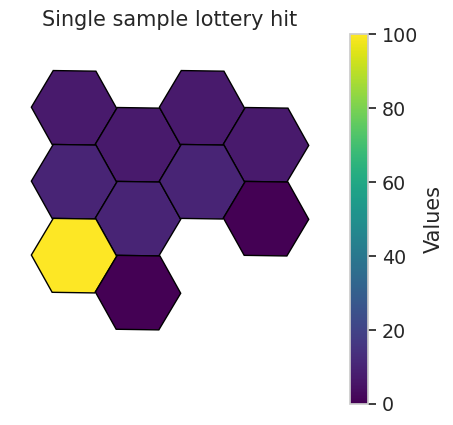

In [12]:
sample_and_plot(dist_N, size=1000, average=False, index=-6, title='Single sample lottery hit')

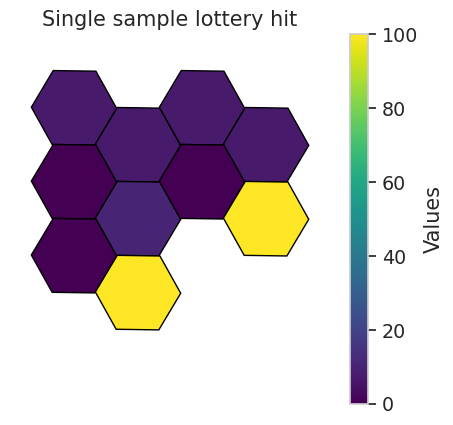

In [11]:
sample_and_plot(dist_N, size=1000, average=False, index=-10, title='Single sample lottery hit')

In [23]:
def calc_bpr_many_trials(
        dist_N, K=3, n_trials=10000, seed=101,
        strategy='pick_mean',
        percentile_as_frac=0.95):
    N = len(dist_N)
    y_RN = np.zeros((n_trials, N), dtype=np.int32)
    for n, dist in enumerate(dist_N):
        random_state = np.random.RandomState(10000 * seed + n)
        y_RN[:, n] = dist.rvs(size=n_trials, random_state=random_state)

    if strategy == 'cross_ratio':
        S = 100*n_trials
        y_SN = np.zeros((S, N))
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_SN[:,n] = dist.rvs(size=S, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_SN[:,n], p)
                                    for p in [0, 10, 50, 90, 100]])
        ratio_N = np.mean(y_SN / np.sum(y_SN, axis=1, keepdims=1), axis=0)
        assert ratio_N.shape == (N,)
        selected_ids_K = np.argsort(-1 * ratio_N)[:K]
        for kk in selected_ids_K:
            print(sum_str_N[kk])
        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    if strategy == 'cross_ratio_topk':
        S = 100*n_trials
        y_SN = np.zeros((S, N))
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_SN[:,n] = dist.rvs(size=S, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_SN[:,n], p)
                                    for p in [0, 10, 50, 90, 100]])

        topk_ids_SN = np.argsort(-1 * y_SN, axis=1)[:, :K]
        topk_y_SN = np.take_along_axis(y_SN, topk_ids_SN, axis=1)
        ratiotopk_N = np.mean(y_SN / np.sum(topk_y_SN, axis=1, keepdims=1), axis=0)
        assert ratiotopk_N.shape == (N,)
        selected_ids_K = np.argsort(-1 * ratiotopk_N)[:K]
        for kk in selected_ids_K:
            print(sum_str_N[kk])
        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    if strategy == 'guess_random':
        random_state = np.random.RandomState(10000 * seed)
        selected_ids_RK = np.zeros((n_trials, K), dtype=np.int32)
        for trial in range(n_trials):
            selected_ids_RK[trial,:] = random_state.permutation(N)[:K]

    if strategy.count('pick'):
        score_N = np.zeros(N)
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_samples_S = dist.rvs(size=100*n_trials, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_samples_S, p)
                                    for p in [0, 10, 50, 90, 100]])
            
            if strategy == 'pick_mean':
                score_N[n] = np.mean(y_samples_S)
            if strategy == 'pick_consistent':
                score_N[n] = 1 if n < 4 else 0
            if strategy == 'pick_variance':
                score_N[n] = 1 if n >=4 and n < 7 else 0
            if strategy == 'pick_lottery':
                score_N[n] = 1 if n >=7 else 0
            if strategy == 'pick_each':
                score_N[n] = 1 if n == 0 or n==4 or n==7 else 0
            if strategy == 'pick_median':
                score_N[n] = np.median(y_samples_S)
            elif strategy == 'pick_percentile':
                score_N[n] = np.percentile(y_samples_S, percentile_as_frac)  

        selected_ids_K = np.argsort(-1 * score_N)[:K]
        print(selected_ids_K)
        for kk in selected_ids_K:
            print(sum_str_N[kk])
        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    yselect_RK = np.take_along_axis(y_RN, selected_ids_RK, axis=1)
    topk_ids_RK = np.argsort(-1 * y_RN, axis=1)[:, :K]
    ytop_RK = np.take_along_axis(y_RN, topk_ids_RK, axis=1)

    numer_R = np.sum(yselect_RK, axis=1)
    denom_R = np.sum(ytop_RK, axis=1)
    
    assert np.all(numer_R <= denom_R + 1e-10)
    
    return numer_R / denom_R


In [12]:
result = calc_bpr_many_trials(dist_N)
result.shape

[8 9 7]
0.0 0.0 0.0 100.0 100.0
0.0 0.0 0.0 0.0 100.0
0.0 0.0 0.0 0.0 100.0


(10000,)

In [17]:
mnames = ['pick_consistent','pick_cross_ratio', 'pick_cross_ratio_topk','pick_median','pick_variance','pick_lottery', 'pick_mean', 'pick_each']
R = 10000

scores_MR = np.zeros((8, R))
for mm, method in enumerate(mnames):
    scores_MR[mm] = calc_bpr_many_trials(
        dist_N, K=3, n_trials=R, strategy=method)
    
winscore_1R = scores_MR.max(axis=0, keepdims=1)

winners_MR = np.abs(scores_MR - winscore_1R) < 0.02

[0 1 2]
7.0 7.0 7.0 7.0 7.0
6.0 7.0 7.0 7.0 7.0
7.0 7.0 7.0 7.0 8.0
[0 1 2]
7.0 7.0 7.0 7.0 7.0
6.0 7.0 7.0 7.0 7.0
7.0 7.0 7.0 7.0 8.0
[0 1 2]
7.0 7.0 7.0 7.0 7.0
6.0 7.0 7.0 7.0 7.0
7.0 7.0 7.0 7.0 8.0
[5 6 4]
0.0 0.0 10.0 10.0 10.0
0.0 0.0 10.0 10.0 11.0
0.0 0.0 10.0 10.0 11.0
[5 6 4]
0.0 0.0 10.0 10.0 10.0
0.0 0.0 10.0 10.0 11.0
0.0 0.0 10.0 10.0 11.0
[7 8 9]
0.0 0.0 0.0 0.0 100.0
0.0 0.0 0.0 100.0 100.0
0.0 0.0 0.0 0.0 100.0
[8 9 7]
0.0 0.0 0.0 100.0 100.0
0.0 0.0 0.0 0.0 100.0
0.0 0.0 0.0 0.0 100.0
[0 4 7]
7.0 7.0 7.0 7.0 7.0
0.0 0.0 10.0 10.0 11.0
0.0 0.0 0.0 0.0 100.0


In [20]:
for mm, mname in enumerate(mnames):
    print("%25s won % 6d/%d trials" % (mname, winners_MR[mm].sum(), R))

          pick_consistent won   4761/10000 trials
         pick_cross_ratio won   4761/10000 trials
    pick_cross_ratio_topk won   4761/10000 trials
              pick_median won   2554/10000 trials
            pick_variance won   2554/10000 trials
             pick_lottery won   1860/10000 trials
                pick_mean won   1860/10000 trials
                pick_each won    825/10000 trials
